In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression

получаем таблицу значений

In [3]:
df = pd.read_csv('Chicago_hotels.csv', sep=';', decimal=',', na_values=' ')
df = df.drop(columns=["x1", "x2", "x3"])

In [4]:
df.head()

,date1,date2,x4
0,January,1994,72.15
1,February,1994,73.47
2,March,1994,74.91
3,April,1994,79.06
4,May,1994,82.07


Text(0, 0.5, 'average day cost per month, $')

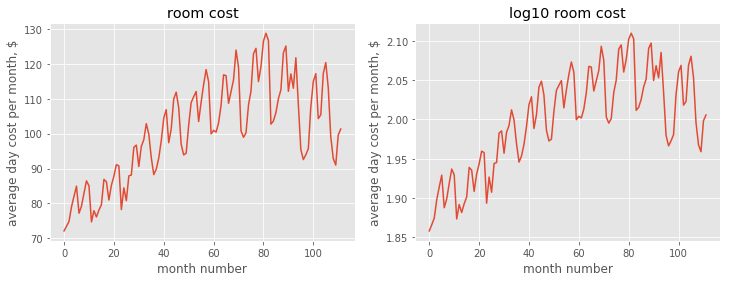

In [6]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['x4'].plot(ax=ax1)
ax1.set_title(u'room cost')
ax1.set_xlabel(u'month number')
ax1.set_ylabel(u'average day cost per month, $')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['x4'])).plot(ax=ax2)
ax2.set_title(u'log10 room cost')
ax2.set_xlabel(u'month number')
ax2.set_ylabel(u'average day cost per month, $')


Прежде, чем заниматься моделью линейной регрессии, обратим внимание, что график меняет свое поведение. Поэтому следует рассматривать только последние 36 месяцев (3 года).

Последние 36 месяцев образуют линейный убывающий тренд. У ряда присутствует сезонность, предположу, что мультипликативная, но данных мало, чтобы утверждать это однозначно. Выбросы отсутствуют.

In [7]:
df2 = df[84:].drop(columns=["date2"])
df2.head()

,date1,x4
84,January,103.61
85,February,106.02
86,March,110.01
87,April,112.55
88,May,123.12


Text(0, 0.5, 'average cost per month, $')

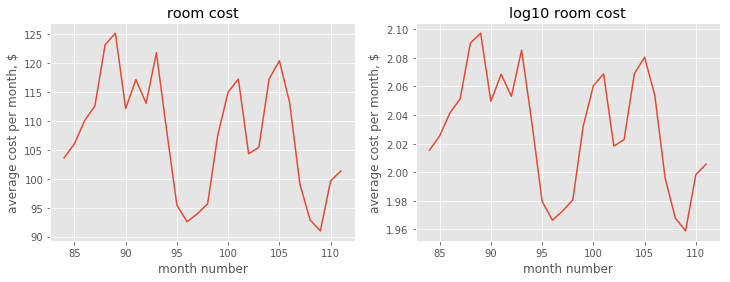

In [8]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df2['x4'].plot(ax=ax1)
ax1.set_title(u'room cost')
ax1.set_xlabel(u'month number')
ax1.set_ylabel(u'average cost per month, $')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df2['x4'])).plot(ax=ax2)
ax2.set_title(u'log10 room cost')
ax2.set_xlabel(u'month number')
ax2.set_ylabel(u'average cost per month, $')

Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год). И прологарифмируем таргет.

In [9]:
df2['month_num'] = range(1, len(df2) + 1)
df2['log_y'] = np.log10(df2['x4'])

In [10]:
df2 = df2.drop(columns=["date1", "x4"])
df2.head()

,month_num,log_y
84,1,2.015402
85,2,2.025388
86,3,2.041432
87,4,2.051345
88,5,2.090329


Создадим новые переменные - индикаторы месяцев

In [11]:
df2["m01"] = [1,0,0,0,0,0,0,0,0,0,0,0]*3
df2["m02"] = [0,1,0,0,0,0,0,0,0,0,0,0]*3
df2["m03"] = [0,0,1,0,0,0,0,0,0,0,0,0]*3
df2["m04"] = [0,0,0,1,0,0,0,0,0,0,0,0]*3
df2["m05"] = [0,0,0,0,1,0,0,0,0,0,0,0]*3
df2["m06"] = [0,0,0,0,0,1,0,0,0,0,0,0]*3
df2["m07"] = [0,0,0,0,0,0,1,0,0,0,0,0]*3
df2["m08"] = [0,0,0,0,0,0,0,1,0,0,0,0]*3
df2["m09"] = [0,0,0,0,0,0,0,0,1,0,0,0]*3
df2["m10"] = [0,0,0,0,0,0,0,0,0,1,0,0]*3
df2["m11"] = [0,0,0,0,0,0,0,0,0,0,1,0]*3
df2["m12"] = [0,0,0,0,0,0,0,0,0,0,0,1]*3


In [12]:
df2.head()

,month_num,log_y,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
84,1,2.015402,1,0,0,0,0,0,0,0,0,0,0,0
85,2,2.025388,0,1,0,0,0,0,0,0,0,0,0,0
86,3,2.041432,0,0,1,0,0,0,0,0,0,0,0,0
87,4,2.051345,0,0,0,1,0,0,0,0,0,0,0,0
88,5,2.090329,0,0,0,0,1,0,0,0,0,0,0,0


In [13]:
#  Создаем матрицу предикторов.
#  Убираем из нее столбец, соответствующий базовому месяцу
X = df2.drop(columns=["m03", "log_y"])
X = X[:len(X)-8]
X.head()

,month_num,m01,m02,m04,m05,m06,m07,m08,m09,m10,m11,m12
84,1,1,0,0,0,0,0,0,0,0,0,0
85,2,0,1,0,0,0,0,0,0,0,0,0
86,3,0,0,0,0,0,0,0,0,0,0,0
87,4,0,0,1,0,0,0,0,0,0,0,0
88,5,0,0,0,1,0,0,0,0,0,0,0


In [14]:
#  Создаем матрицу (столбец) откликов.
y = df2['log_y']
y = y[:len(y)-8]

In [15]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

In [17]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,2.032594,0.000000
1,month_num,-0.001716,0.000302
2,m01,-0.027019,0.065643
3,m02,-0.022808,0.116459
4,m04,0.024496,0.092921
5,m05,0.061703,0.000570
6,m06,0.071020,0.000115
7,m07,0.023661,0.144337
8,m08,0.037113,0.025724
9,m09,0.054152,0.001878


Посмотрим на $R^2$ . (значение получилось довольно неплохим)

In [20]:
model.score(X, y)

0.8960094613701759

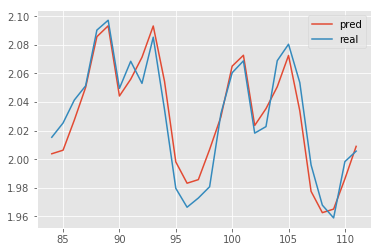

In [21]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

Сделаем прогноз на следующие 8 месяцев

In [22]:
#  Готовим маторицу для вычисления прогнозов
#  Сначала время
df_3 = pd.DataFrame()

df_3['month_num'] = range(36, 44)
df_3

,month_num
0,36
1,37
2,38
3,39
4,40
5,41
6,42
7,43


In [23]:
#  Добавляем индикаторы месяцев. Данные кончились на апреле, а достроить нужно до декабря, поэтому используем следующую маттрицу
df_3["m01"] = [0,0,0,0,0,0,0,0]
df_3["m02"] = [0,0,0,0,0,0,0,0]
# df_3["m03"] = [0,0,0,0,0,0,0,0]
df_3["m04"] = [0,0,0,0,0,0,0,0]
df_3["m05"] = [1,0,0,0,0,0,0,0]
df_3["m06"] = [0,1,0,0,0,0,0,0]
df_3["m07"] = [0,0,1,0,0,0,0,0]
df_3["m08"] = [0,0,0,1,0,0,0,0]
df_3["m09"] = [0,0,0,0,1,0,0,0]
df_3["m10"] = [0,0,0,0,0,1,0,0]
df_3["m11"] = [0,0,0,0,0,0,1,0]
df_3["m12"] = [0,0,0,0,0,0,0,1]


In [24]:
df_3.head()

,month_num,m01,m02,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,36,0,0,0,1,0,0,0,0,0,0,0
1,37,0,0,0,0,1,0,0,0,0,0,0
2,38,0,0,0,0,0,1,0,0,0,0,0
3,39,0,0,0,0,0,0,1,0,0,0,0
4,40,0,0,0,0,0,0,0,1,0,0,0


In [25]:
#  Прогноз для логарфмов
model.predict(df_3)


array([2.03251463, 2.04011535, 1.9910408 , 2.00277605, 2.01809887,
       2.03999986, 2.0012783 , 1.94497513])

In [26]:
#  Прогноз для исходного ряда
y1 = 10**model.predict(df_3)
y1

array([107.77415653, 109.67694696,  97.95820128, 100.64125641,
       104.25547445, 109.64778441, 100.2947731 ,  88.09984221])

In [27]:
#  матрица с подгонкой
pred['forecast'] = np.nan
pred.head()

,pred,real,forecast
84,2.003859,2.015402,NaN
85,2.006353,2.025388,NaN
86,2.027445,2.041432,NaN
87,2.050225,2.051345,NaN
88,2.085716,2.090329,NaN


In [28]:
#  матрица с прогнозом
df_4 = pd.DataFrame(model.predict(df_3), columns=['forecast'])
df_4['real'] = np.nan
df_4['pred'] = np.nan
df_4.head()

,forecast,real,pred
0,2.032515,NaN,NaN
1,2.040115,NaN,NaN
2,1.991041,NaN,NaN
3,2.002776,NaN,NaN
4,2.018099,NaN,NaN


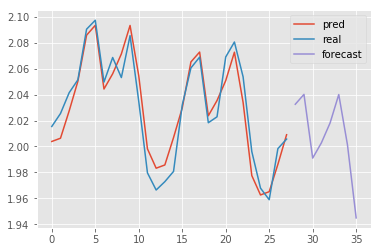

In [29]:
#  объединяем матрицы, задаем новые индексы
pred_1 = pd.concat(
    [pred, df_4],
    sort=False
).reset_index(drop=True)
pred_1.plot()

In [30]:
pred_11 = 10**pred_1

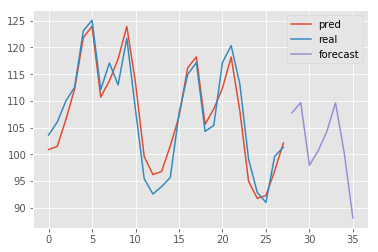

In [31]:
pred_11.plot()

In [32]:
#  Прогнозируемая стоимость:
y1 = 10**(df_4)
y1 = y1.drop(columns = ["real", "pred"])
y1['month'] = ["May", "June", "July", "August", "September", "October", "November", "December"]
y1

,forecast,month
0,107.774157,May
1,109.676947,June
2,97.958201,July
3,100.641256,August
4,104.255474,September
5,109.647784,October
6,100.294773,November
7,88.099842,December


Спронозированные данные кажутся верными, поскольку сохранена сезонность и тренд.